# Hand Landmark Model

In [1]:
import os

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.distance import pdist, squareform

from nets import hand_landmark_model

In [2]:
COLORS = ['r', 'red', 'red', 'red', 'red', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'gold', 'gold', 'gold', 'gold', 'limegreen', 'limegreen', 'limegreen', 'limegreen', 'deeppink', 'deeppink', 'deeppink', 'deeppink']
JOINT_NAME = ['Wrist', 'TMCP', 'TPIP', 'TDIP', 'TTIP', 'IMCP', 'IPIP', 'IDIP', 'ITIP', 'MMCP', 'MPIP', 'MDIP', 'MTIP', 'RMCP', 'RPIP', 'RDIP', 'RTIP', 'PMCP', 'PPIP', 'PDIP', 'PTIP']

In [3]:
def draw_skeleton(landmarks, points_size=30, line_width=3):
    xs, ys = [p[0] for p in landmarks], [p[1] for p in landmarks]
    for i in range(1, 18, 4):
        temp_x = [xs[0]] + [xs[i+j] for j in range(4)]
        temp_y = [ys[0]] + [ys[i+j] for j in range(4)]
        plt.plot(temp_x, temp_y, c=COLORS[i], linewidth=line_width, alpha=0.7)
    plt.scatter(landmarks[:,0], landmarks[:,1], color='steelblue', s=points_size, alpha=1)
    return None

![](https://i.imgur.com/IYqiSYA.png)

## Model Structure

In [4]:
TFLITE_MODEL_PATH = 'original_model/hand_landmark.tflite'
release_model = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)

In [5]:
model = hand_landmark_model.build_hand_landmark_model()

In [6]:
# model.save("./model/model.h5")

In [7]:
layer_name_list = []
layer_shape_list = []
for layer in model.layers:
    name = layer.name
    if "input" in name or "concat" in name:
        output_shape = list(layer.output_shape[0])
    else:
        output_shape = list(layer.output_shape)
    output_shape[0] = 1
    if "conv2d" in name:
        layer_name_list.append(name + '/Kernel')
        layer_name_list.append(name + '/Bias')
        layer_name_list.append(name)
        if 'dep' in layer.name:
            layer_shape_list.append(list(np.array(layer.depthwise_kernel.shape)[[3, 0, 1, 2]]))
        else:
            layer_shape_list.append(list(np.array(layer.kernel.shape)[[3, 0, 1, 2]]))
        layer_shape_list.append([output_shape[-1]])
        layer_shape_list.append(output_shape)
    elif "p_re_lu" in name:
        layer_name_list.append(name + '/Alpha')
        layer_name_list.append(name)
        layer_shape_list.append([1,1,layer.output_shape[-1]])
        layer_shape_list.append(output_shape)
    elif "tf_op_layer_zeros_like" in name:
        continue
    elif "concat" in name:
        layer_name_list.append('channel_padding/Paddings')
        layer_name_list.append('channel_padding')
        layer_shape_list.append([4, 2])
        layer_shape_list.append(output_shape)
    else:
        layer_name_list.append(name)
        layer_shape_list.append(output_shape)
for i, layer in enumerate(release_model.get_tensor_details()):
    if i < len(layer_name_list):
        if layer_shape_list[i] == layer["shape"].tolist():
            print(layer["name"].ljust(30), 
                  str(layer["shape"].tolist()).ljust(20), 
                  layer_name_list[i].ljust(30), 
                  str(layer_shape_list[i]).ljust(20), "OK")
        else:
            print(layer["name"].ljust(30), 
                  str(layer["shape"].tolist()).ljust(20), 
                  layer_name_list[i].ljust(30), 
                  str(layer_shape_list[i]).ljust(20), "Not identical!")

    else:
        print(layer["name"].ljust(30), str(layer["shape"].tolist()).ljust(20))

input_1                        [1, 256, 256, 3]     input_1                        [1, 256, 256, 3]     OK
conv2d/Kernel                  [16, 3, 3, 3]        conv2d/Kernel                  [16, 3, 3, 3]        OK
conv2d/Bias                    [16]                 conv2d/Bias                    [16]                 OK
conv2d                         [1, 128, 128, 16]    conv2d                         [1, 128, 128, 16]    OK
p_re_lu/Alpha                  [1, 1, 16]           p_re_lu/Alpha                  [1, 1, 16]           OK
p_re_lu                        [1, 128, 128, 16]    p_re_lu                        [1, 128, 128, 16]    OK
conv2d_1/Kernel                [8, 1, 1, 16]        conv2d_1/Kernel                [8, 1, 1, 16]        OK
conv2d_1/Bias                  [8]                  conv2d_1/Bias                  [8]                  OK
conv2d_1                       [1, 128, 128, 8]     conv2d_1                       [1, 128, 128, 8]     OK
p_re_lu_1/Alpha                [1, 1,

depthwise_conv2d_23/Bias       [32]                 depthwise_conv2d_23/Bias       [32]                 OK
depthwise_conv2d_23            [1, 32, 32, 32]      depthwise_conv2d_23            [1, 32, 32, 32]      OK
conv2d_48/Kernel               [64, 1, 1, 32]       conv2d_48/Kernel               [64, 1, 1, 32]       OK
conv2d_48/Bias                 [64]                 conv2d_48/Bias                 [64]                 OK
conv2d_48                      [1, 32, 32, 64]      conv2d_48                      [1, 32, 32, 64]      OK
add_23                         [1, 32, 32, 64]      add_23                         [1, 32, 32, 64]      OK
p_re_lu_48/Alpha               [1, 1, 64]           p_re_lu_48/Alpha               [1, 1, 64]           OK
p_re_lu_48                     [1, 32, 32, 64]      p_re_lu_48                     [1, 32, 32, 64]      OK
conv2d_49/Kernel               [32, 1, 1, 64]       conv2d_49/Kernel               [32, 1, 1, 64]       OK
conv2d_49/Bias                 [32]  

add_48                         [1, 4, 4, 256]       add_48                         [1, 4, 4, 256]       OK
p_re_lu_98/Alpha               [1, 1, 256]          p_re_lu_98/Alpha               [1, 1, 256]          OK
p_re_lu_98                     [1, 4, 4, 256]       p_re_lu_98                     [1, 4, 4, 256]       OK
conv2d_99/Kernel               [128, 1, 1, 256]     conv2d_99/Kernel               [128, 1, 1, 256]     OK
conv2d_99/Bias                 [128]                conv2d_99/Bias                 [128]                OK
conv2d_99                      [1, 4, 4, 128]       conv2d_99                      [1, 4, 4, 128]       OK
p_re_lu_99/Alpha               [1, 1, 128]          p_re_lu_99/Alpha               [1, 1, 128]          OK
p_re_lu_99                     [1, 4, 4, 128]       p_re_lu_99                     [1, 4, 4, 128]       OK
depthwise_conv2d_49/Kernel     [1, 3, 3, 128]       depthwise_conv2d_49/Kernel     [1, 3, 3, 128]       OK
depthwise_conv2d_49/Bias       [128] 

In [8]:
tf.keras.utils.plot_model(model, 
                          to_file=os.path.join('nets', 'hand_landmark_model.png'), 
                          show_shapes=True, 
                          show_layer_names=True, 
                          rankdir='TB', 
                          expand_nested=False,
                          dpi=96)

In [9]:
x = np.float32(np.random.random((8, 256, 256, 3)))
prediction = model(x)

In [10]:
print("shape of model ouput: %s \n(batch_size, hand_presence + hand_landmark)" % (prediction.shape))

shape of model ouput: (8, 42) 
(batch_size, hand_presence + hand_landmark)


## Affine Transformation

![](https://docs.opencv.org/3.4/Warp_Affine_Tutorial_Theory_0.jpg)

## Test on simple grid image

In [11]:
image_shape = (256, 256, 3)
image = np.ones(image_shape)*1
for i in range(0+16, 257-16, 16):
    cv2.line(image, (0, i), (256, i), (0.8, 0.8, 0.8), 1)
    cv2.line(image, (i, 0), (i, 256), (0.8, 0.8, 0.8), 1)
    
x = np.random.randint(0, 100)
y = np.random.randint(0, 100)
w = np.random.randint(80, 150)
image = cv2.rectangle(image, (x, y), (x+w, y+w), (0, 0, 0), -1)

triangle_points = [(x, y), (x+w, y), (x, y+w)]
for p in triangle_points:
    image = cv2.circle(image, p, 2, (0,1,0), 2)

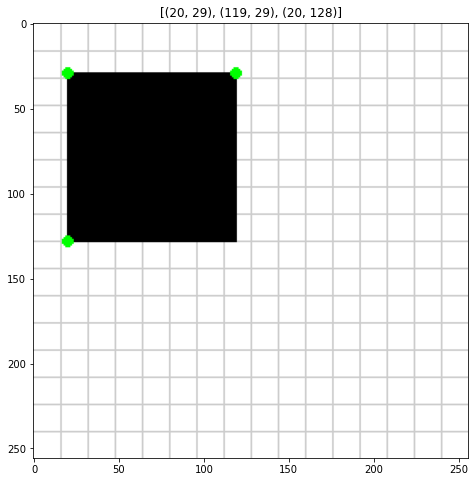

In [12]:
plt.figure(figsize=(8, 8))
plt.title(triangle_points)
plt.imshow(image)
plt.show()

In [13]:
height, width, channel = image_shape

In [14]:
original_tri = np.float32(triangle_points)

In [15]:
target_tri = np.float32(triangle_points)
target_tri[0][0] += 0 
target_tri[0][1] += 0
target_tri[1][0] += 0
target_tri[1][1] += 0
target_tri[2][0] += -69
target_tri[2][1] += -69

In [16]:
matrix = cv2.getAffineTransform(original_tri, target_tri)
inv_matrix = cv2.getAffineTransform(target_tri, original_tri)

In [17]:
transformed_image = cv2.warpAffine(image, matrix, (width, height))
transformed_back_image = cv2.warpAffine(transformed_image, inv_matrix, (width, height))

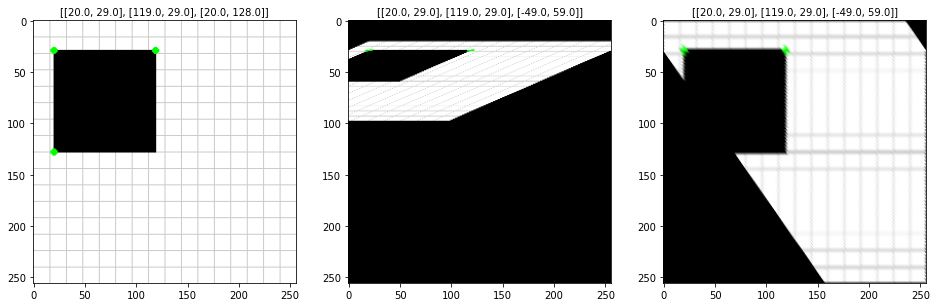

In [18]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title(original_tri.tolist(), fontsize=10)
plt.imshow(image)

plt.subplot(132)
plt.title(target_tri.tolist(), fontsize=10)
plt.imshow(transformed_image)

plt.subplot(133)
plt.title(target_tri.tolist(), fontsize=10)
plt.imshow(transformed_back_image)

plt.show()

## Test on hand image

The output of palm detector is bounding boxes and list of 7 key points coordinates on 256x256 image    
In order to reduce the comlexity of the regression task,   
it's crucial to align the hand image by affine transform    
which performs crop, resize and rotate to get hand region with specific angle

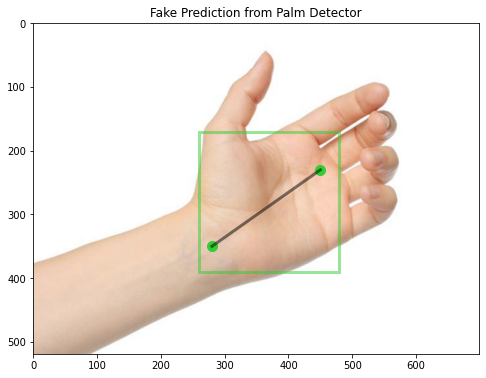

In [19]:
image = cv2.imread(os.path.join('test_image', 'hand.jpg'))/255
cx = 370
cy = 280
w = 220
kp0, kp2 = (280, 350), (450, 230)

plt.figure(figsize=(8, 8))
plt.title("Fake Prediction from Palm Detector")

plt.scatter(np.float32([kp0, kp2])[:,0], np.float32([kp0, kp2])[:,1], color='limegreen', s=100)
plt.plot(np.float32([kp0, kp2])[:,0], np.float32([kp0, kp2])[:,1], c='k', lw=3, alpha=0.5)
rect = patches.Rectangle((cx-w//2, cy-w//2), w, w, lw=3, ec='limegreen', ls='-', alpha=.5, fc="none")
plt.gca().add_patch(rect)


plt.imshow(image[:,:,::-1])
plt.show()

Calculate the triangle for affine transformation

In [20]:
# Target is to move kp2 to center (128, 128), crop and resize to (256, 256) image with given box size
TARGET_TRIANGLE = np.float32([[128, 128], [128, 0], [0, 128]])

def get_triangle(kp0, kp2, w):
    # BOX_ENLARGE
    side = w * 1.3 
    dir_v = kp2 - kp0
    dir_v /= np.linalg.norm(dir_v)
    dir_v_r = dir_v @ np.r_[[[0, 1], [-1, 0]]].T
    source = np.float32([kp2, kp2 + dir_v * side, kp2 + dir_v_r * side])
    # BOX_SHIFT
    source -= (kp0-kp2) * 0.2
    return source


def warp_affine(padding_image, source):
    Mtr = cv2.getAffineTransform(source * IMAGE_WIDTH / INPUT_WIDTH, TARGET_TRIANGLE)
    img_landmark = cv2.warpAffine(padding_image, Mtr, (INPUT_WIDTH, INPUT_HEIGHT))
    return img_landmark

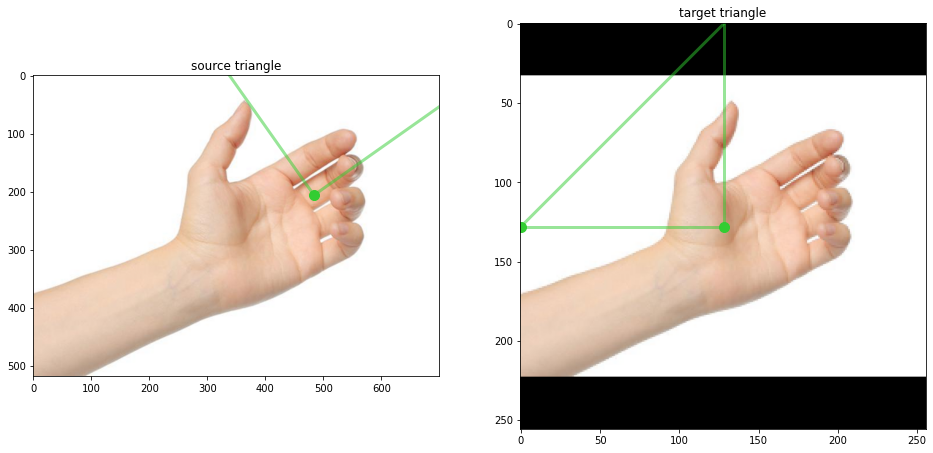

In [21]:
image = cv2.imread(os.path.join('test_image', 'hand.jpg'))/255

target_image = image.copy()
shape = np.int32(target_image.shape)
padding = (shape.max() - shape[:2]).astype('uint32') // 2
target_image = np.pad(target_image, ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant')
target_image = cv2.resize(target_image, image_shape[:2][::-1])

tri = get_triangle(np.float32(kp0), np.float32(kp2), w*1.3)    


    
plt.figure(figsize=(16, 8))

plt.subplot(121)
src_tri_image = image.copy()
for index in [[0, 1], [1, 2], [2, 0]]:
    plt.plot(tri[index][:,0], tri[index][:,1], c='limegreen', lw=3, alpha=0.5)
plt.scatter(tri[index][:,0], tri[index][:,1], color='limegreen', s=100)
plt.title("source triangle")
plt.imshow(src_tri_image[:,:,::-1])

plt.subplot(122)
dst_tri_image = target_image.copy()
for index in [[0, 1], [1, 2], [2, 0]]:
    plt.plot(TARGET_TRIANGLE[index][:,0], TARGET_TRIANGLE[index][:,1], c='limegreen', lw=3, alpha=0.5)
plt.scatter(TARGET_TRIANGLE[index][:,0], TARGET_TRIANGLE[index][:,1], color='limegreen', s=100)
plt.title("target triangle")
plt.imshow(dst_tri_image[:,:,::-1])

plt.show()

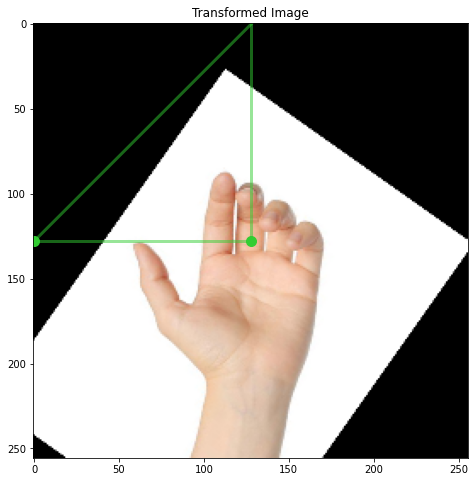

In [22]:
transformed_image = image.copy()
matrix = cv2.getAffineTransform(tri, TARGET_TRIANGLE)
transformed_image = cv2.warpAffine(transformed_image, matrix, (256, 256))
    
plt.figure(figsize=(8, 8))
for index in [[0, 1], [1, 2], [2, 0]]:
    plt.plot(TARGET_TRIANGLE[index][:,0], TARGET_TRIANGLE[index][:,1], c='limegreen', lw=3, alpha=0.5)
plt.scatter(TARGET_TRIANGLE[index][:,0], TARGET_TRIANGLE[index][:,1], color='limegreen', s=100)
plt.title("Transformed Image")
plt.imshow(transformed_image[:,:,::-1])
plt.show()

> This is the format of input image for hand landmark model

## Transform points with given matrix

Assume that we have already had the key points annotations of original image    
We could calculate the affine transform matrix and obtain the proper(aligned) input image    
The next step is to convert the coordinates according to the transformed hand region image    
then the training input image and labels for model will be compatible

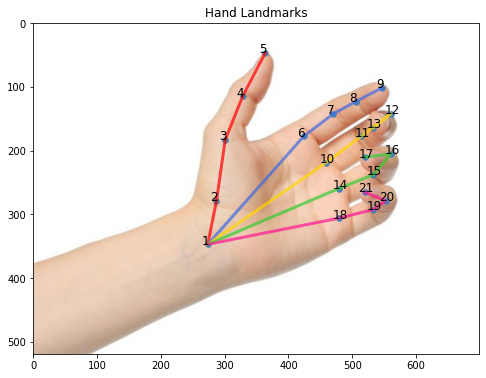

In [23]:
image = cv2.imread(os.path.join('test_image', 'hand.jpg'))/255
points_image = image.copy()
points = np.float32([[273.4375  , 346.875   ],
                    [287.10938 , 278.61328 ],
                    [300.78125 , 183.04688 ],
                    [328.125   , 114.78516 ],
                    [363.67188 ,  46.523438],
                    [423.82812 , 177.58594 ],
                    [470.3125  , 142.08984 ],
                    [505.85938 , 122.97656 ],
                    [546.875   , 101.13281 ],
                    [459.375   , 218.54297 ],
                    [514.0625  , 177.58594 ],
                    [560.5469  , 142.08984 ],
                    [533.2031  , 163.9336  ],
                    [478.51562 , 259.5     ],
                    [533.2031  , 237.65625 ],
                    [560.5469  , 204.89062 ],
                    [519.53125 , 210.35156 ],
                    [478.51562 , 305.91797 ],
                    [533.2031  , 292.26562 ],
                    [552.34375 , 278.61328 ],
                    [519.53125 , 264.96094 ]])

plt.figure(figsize=(8, 8))
draw_skeleton(points)
xs, ys = [p[0] for p in points], [p[1] for p in points]
for i in range(len(xs)): plt.text(xs[i]-10, ys[i], str(i+1), fontsize=12)    
plt.title("Hand Landmarks")
plt.imshow(points_image[:,:,::-1])
plt.show()

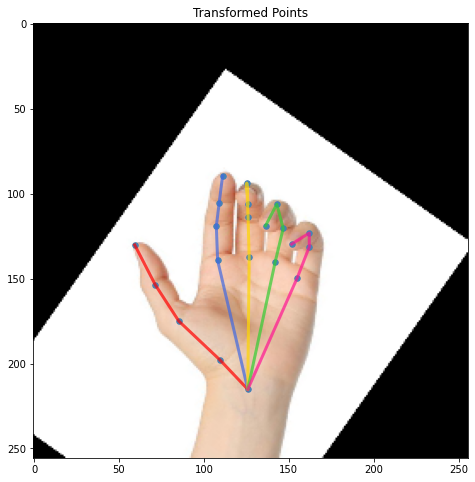

In [24]:
transformed_image = image.copy()
matrix = cv2.getAffineTransform(tri, TARGET_TRIANGLE)
transformed_image = cv2.warpAffine(transformed_image, matrix, (256, 256))

ones = np.ones(shape=(len(points), 1))
points_ones = np.hstack([points, ones])
transformed_points = matrix.dot(points_ones.T).T


plt.figure(figsize=(8, 8))
draw_skeleton(transformed_points)
plt.title("Transformed Points")
plt.imshow(transformed_image[:,:,::-1])
plt.show()

## Transform points back to original coordinate space

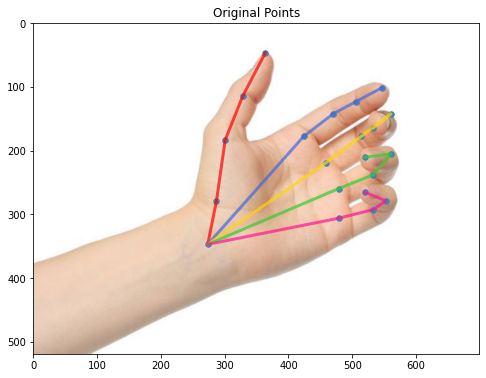

In [25]:
transformed_back_image = image.copy()

inv_matrix = np.pad(matrix.T, ((0, 0), (0, 1)), constant_values=1, mode='constant').T
inv_matrix[2, :2] = 0
inv_matrix = np.linalg.inv(inv_matrix)
ones = np.ones(shape=(len(transformed_points), 1))
transformed_points_ones = np.hstack([transformed_points, ones])
transformed_back_points = inv_matrix.dot(transformed_points_ones.T).T

plt.figure(figsize=(8, 8))
draw_skeleton(transformed_back_points)
plt.title("Original Points")
plt.imshow(transformed_back_image[:,:,::-1])
plt.show()

## Encode Training Sample from Raw Data

create image and annotation    

In [26]:
image = cv2.imread(os.path.join('test_image', 'hand.jpg'))
annotation = np.float32([1,
                         273.4375  , 346.875   , 287.10938 , 278.61328 , 300.78125 ,
                        183.04688 , 328.125   , 114.78516 , 363.67188 ,  46.523438,
                        423.82812 , 177.58594 , 470.3125  , 142.08984 , 505.85938 ,
                        122.97656 , 546.875   , 101.13281 , 459.375   , 218.54297 ,
                        514.0625  , 177.58594 , 560.5469  , 142.08984 , 533.2031  ,
                        163.9336  , 478.51562 , 259.5     , 533.2031  , 237.65625 ,
                        560.5469  , 204.89062 , 519.53125 , 210.35156 , 478.51562 ,
                        305.91797 , 533.2031  , 292.26562 , 552.34375 , 278.61328 ,
                        519.53125 , 264.96094
                         ])
print('image shape: %s\nannotation shape: %s' % (image.shape, annotation.shape))
print("annotation: (hand presence + 21 key points) = (1 + 42) = 43")

image shape: (519, 700, 3)
annotation shape: (43,)
annotation: (hand presence + 21 key points) = (1 + 42) = 43


In [27]:
COLORS = ['r', 'red', 'red', 'red', 'red', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'gold', 'gold', 'gold', 'gold', 'limegreen', 'limegreen', 'limegreen', 'limegreen', 'deeppink', 'deeppink', 'deeppink', 'deeppink']
JOINT_NAME = ['Wrist', 'TMCP', 'TPIP', 'TDIP', 'TTIP', 'IMCP', 'IPIP', 'IDIP', 'ITIP', 'MMCP', 'MPIP', 'MDIP', 'MTIP', 'RMCP', 'RPIP', 'RDIP', 'RTIP', 'PMCP', 'PPIP', 'PDIP', 'PTIP']

convert raw image to input image

In [28]:
def get_triangle(wrist, mmcp, w):
    side = w * BOX_ENLARGE 
    dir_v = mmcp - wrist 
    dir_v /= np.linalg.norm(dir_v)
    dir_v_r = dir_v @ np.r_[[[0, 1], [-1, 0]]].T
    triangle = np.float32([mmcp, mmcp + dir_v * side, mmcp + dir_v_r * side])
    triangle -= (wrist - mmcp) * BOX_SHIFT
    return triangle

In [29]:
def max_distance(points):
    d = pdist(points)
    d = squareform(d)
    return np.nanmax(d)

In [30]:
def encode_landmarks(lanmarks, matrix):
    ones = np.ones(shape=(len(lanmarks), 1))
    lanmarks_ones = np.hstack([lanmarks, ones])
    encoded_lanmarks = matrix.dot(lanmarks_ones.T).T
    return encoded_lanmarks

In [31]:
TARGET_TRIANGLE = np.float32([[128, 128], [128, 0], [0, 128]])
BOX_ENLARGE = 1.3
BOX_SHIFT = 0.2

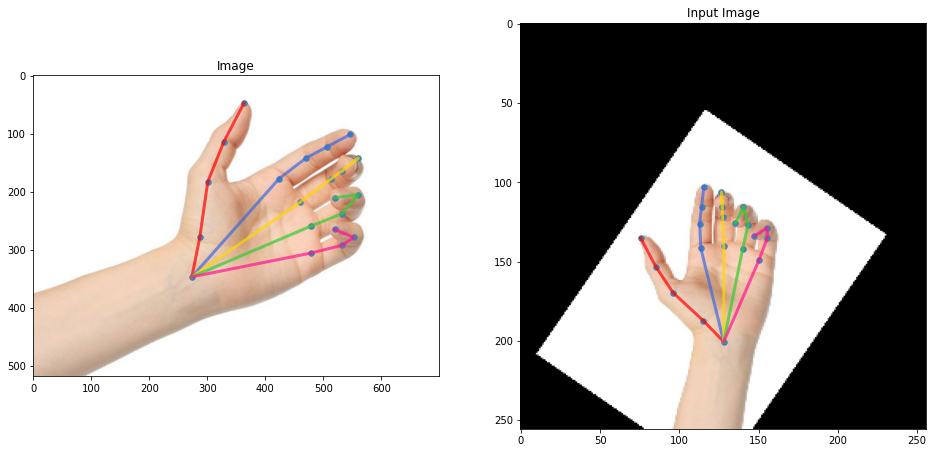

In [32]:
landmarks = annotation[1:].reshape(-1, 2)
# input_image
#================================================================================
w = max_distance(landmarks)
triangle = get_triangle(landmarks[0], landmarks[9], w)
matrix = cv2.getAffineTransform(triangle, TARGET_TRIANGLE)
input_image = image.copy()
input_image = cv2.warpAffine(input_image, matrix, (256, 256))
encoded_landmarks = encode_landmarks(landmarks, matrix)
# vidualize
#================================================================================
plt.figure(figsize=(16, 8))

plt.subplot(121)
draw_skeleton(landmarks)
plt.title("Image")
plt.imshow(image[:,:,::-1])

plt.subplot(122)
draw_skeleton(encoded_landmarks)
plt.title("Input Image")
plt.imshow(input_image[:,:,::-1])

plt.show()

## Positive and Nagetive Samples


> For hand presence, we select a subset of real-world images as positive examples    
> and sample on the region **excluding annotated hand regions as negative examples**.

**Need a function to randomly crop negative examples from original image**    
**The alternative approach is to collect background images that containd no hands**

## Create one raw data

In [33]:
from utils.encoder import encode_landmarks, max_distance, preprocess, get_triangle

In [34]:
COLORS = ['r', 'red', 'red', 'red', 'red', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'gold', 'gold', 'gold', 'gold', 'limegreen', 'limegreen', 'limegreen', 'limegreen', 'deeppink', 'deeppink', 'deeppink', 'deeppink']
JOINT_NAME = ['Wrist', 'TMCP', 'TPIP', 'TDIP', 'TTIP', 'IMCP', 'IPIP', 'IDIP', 'ITIP', 'MMCP', 'MPIP', 'MDIP', 'MTIP', 'RMCP', 'RPIP', 'RDIP', 'RTIP', 'PMCP', 'PPIP', 'PDIP', 'PTIP']

In [35]:
TARGET_TRIANGLE = np.float32([[128, 128], [128, 0], [0, 128]])

In [36]:
raw_image = cv2.imread(os.path.join('test_image', 'hand2.jpg'))

In [37]:
raw_annotation = np.float32([[1, 0.27600849, 0.86666667, 0.1910828, 0.73333333, 0.13800425,
                                   0.61666667, 0.08492569, 0.5, 0., 0.41666667,
                                   0.21868365, 0.41666667, 0.1910828, 0.25, 0.17622081,
                                   0.16666667, 0.15923567, 0.04333333, 0.2866242, 0.4,
                                   0.28025478, 0.22666667, 0.27176221, 0.11666667, 0.27176221,
                                   0., 0.33970276, 0.45, 0.36093418, 0.28333333,
                                   0.37154989, 0.2, 0.38216561, 0.08333333, 0.40339703,
                                   0.5, 0.42462845, 0.41666667, 0.44585987, 0.33333333,
                                   0.4670913, 0.25
                                   ],
                                  [1, 0.72399151, 0.86666667, 0.8089172, 0.73333333, 0.86199575,
                                   0.61666667, 0.91507431, 0.53333333, 0.98726115, 0.44333333,
                                   0.78131635, 0.41666667, 0.8089172, 0.25, 0.82377919,
                                   0.16666667, 0.84076433, 0.07666667, 0.7133758, 0.4,
                                   0.71974522, 0.22666667, 0.72823779, 0.11666667, 0.72823779,
                                   0.01666667, 0.66029724, 0.43333333, 0.63906582, 0.28333333,
                                   0.62845011, 0.2, 0.61783439, 0.08333333, 0.59660297,
                                   0.5, 0.57537155, 0.41666667, 0.55414013, 0.33333333,
                                   0.5329087, 0.25]
                                  ])

# original_annotation = np.float32([[1, 
#                                    130, 260,
#                                    90, 220, 65, 185, 40, 150, 0, 125,
#                                    103, 125, 90, 75, 83, 50, 75, 13,
#                                    135, 120, 132, 68, 128, 35, 128, 0,
#                                    160, 135, 170, 85, 175, 60, 180, 25,
#                                    190, 150, 200, 125, 210, 100, 220, 75,],
#                                   [1, 
#                                    341., 260., 
#                                    381., 220., 406., 185., 431., 160., 465., 133.,
#                                    368., 125., 381.,  75., 388.,  50., 396.,  23., 
#                                    336., 120., 339.,  68., 343.,  35., 343.,  5., 
#                                    311., 130., 301.,  85., 296.,  60., 291., 25., 
#                                    281., 150., 271., 125., 261., 100., 251.,  75.]
#                                  ])
# (original_annotation[:,1:][1].reshape(-1, 2) / original_image.shape[:2][::-1]).reshape(1, -1)

hand_presence_list = raw_annotation[:, 0]
landmarks_list = raw_annotation[:, 1:].reshape(-1, 21, 2)

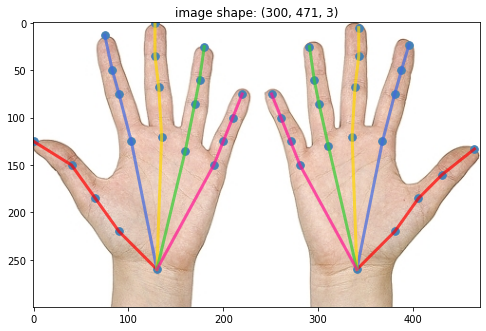

In [38]:
plt.figure(figsize=(8, 8))
for i, landmarks in enumerate(landmarks_list):
    draw_skeleton(landmarks*raw_image.shape[:2][::-1], 58, 3)
plt.imshow(raw_image[:,:,::-1])
plt.title("image shape: %s" % str(raw_image.shape))
plt.show()

## Extract positive samples from the raw data

Apply affine transform to get the hand region and move all landmarks to the correct position

In [39]:
croped_hand_image = []
croped_landmarks = []
for i, landmarks in enumerate(landmarks_list):
    landmarks = landmarks*raw_image.shape[:2][::-1]
    
    w = max_distance((landmarks)[[0, 1, 2, 5, 9, 13, 17]])
    triangle = get_triangle(landmarks[0], landmarks[9], w)
    matrix = cv2.getAffineTransform(triangle, TARGET_TRIANGLE)
    
    input_image = cv2.warpAffine(raw_image, matrix, (256, 256))
    encoded_landmarks = encode_landmarks(landmarks, matrix)

    croped_hand_image.append(input_image)
    croped_landmarks.append(encoded_landmarks)

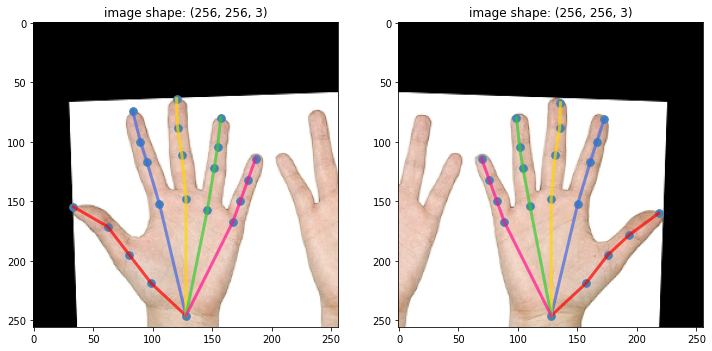

In [40]:
plt.figure(figsize=(12, 6))
for i in range(len(croped_hand_image)):
    plt.subplot(1, 2, i+1)
    draw_skeleton(croped_landmarks[i], 58, 3)
    plt.imshow(croped_hand_image[i][:,:,::-1])
    plt.title("image shape: %s" % str(croped_hand_image[i].shape))
plt.show()

> The `croped_hand_image` and `croped_landmarks` are the positive samples

## Check Collected Raw Data

In [41]:
import json
import glob

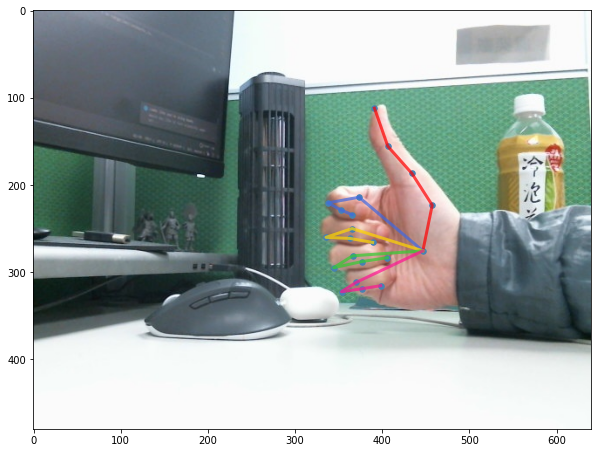

In [118]:
random_selected_file = os.path.split(np.random.choice(glob.glob('data/raw/image/*')))[-1].split('.')[0]
image = cv2.imread(os.path.join('data', 'raw', 'image', random_selected_file + '.jpg'))[:,:,::-1]
with open(os.path.join('data', 'raw', 'annotation', random_selected_file + '.json')) as json_file: anno = json.load(json_file)

plt.figure(figsize=(10,8))
for i in range(len(anno)): draw_skeleton(np.array(anno[i]['landmark']))
plt.imshow(image)
plt.show()

## Convert Raw Data to Training Data

In [58]:
random_selected_file = os.path.split(np.random.choice(glob.glob('data/raw/image/*')))[-1].split('.')[0]
image = cv2.imread(os.path.join('data', 'raw', 'image', random_selected_file + '.jpg'))[:,:,::-1]
with open(os.path.join('data', 'raw', 'annotation', random_selected_file + '.json')) as json_file: anno = json.load(json_file)
raw_image = image.copy()

In [59]:
croped_hand_image = []
croped_landmarks = []
for i, landmarks in enumerate(anno):
    landmarks = np.array(landmarks["landmark"])
    
    w = max_distance((landmarks)[[0, 1, 2, 5, 9, 13, 17]])
    triangle = get_triangle(landmarks[0], landmarks[9], w)
    matrix = cv2.getAffineTransform(triangle, TARGET_TRIANGLE)
    
    input_image = cv2.warpAffine(raw_image, matrix, (256, 256))
    encoded_landmarks = encode_landmarks(landmarks, matrix)

    croped_hand_image.append(input_image)
    croped_landmarks.append(encoded_landmarks)

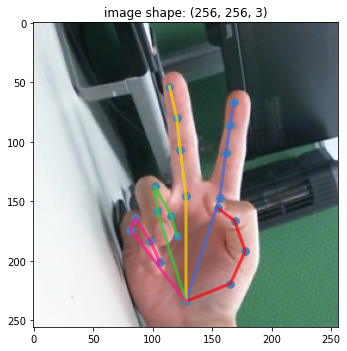

In [60]:
plt.figure(figsize=(12, 6))
for i in range(len(croped_hand_image)):
    plt.subplot(1, 2, i+1)
    draw_skeleton(croped_landmarks[i], 58, 3)
    plt.imshow(croped_hand_image[i])
    plt.title("image shape: %s" % str(croped_hand_image[i].shape))
plt.show()

In [66]:
all_image_path = glob.glob('data/raw/image/*')

In [68]:
class Object(object):
    def __init__(self):
        pass

    def toJSON(self):
        return json.dumps(self.__dict__)

In [83]:
for image_path in all_image_path:
    file_name = os.path.split(image_path)[-1].split('.')[0]
    raw_image = cv2.imread(os.path.join('data', 'raw', 'image', file_name + '.jpg'))
    with open(os.path.join('data', 'raw', 'annotation', file_name + '.json')) as json_file: anno = json.load(json_file)

    for i, landmarks in enumerate(anno):
        landmarks = np.array(landmarks["landmark"])

        w = max_distance((landmarks)[[0, 1, 2, 5, 9, 13, 17]])
        triangle = get_triangle(landmarks[0], landmarks[9], w)
        matrix = cv2.getAffineTransform(triangle, TARGET_TRIANGLE)

        input_image = cv2.warpAffine(raw_image, matrix, (256, 256))
        encoded_landmarks = encode_landmarks(landmarks, matrix)
        
        cv2.imwrite(os.path.join('data', 'image', file_name + str(i) + '.jpg'), input_image)
        
        output = []
        item = Object()
        item.landmark = encoded_landmarks.tolist()
        with open(os.path.join('data', 'annotation', file_name  + str(i) + '.json'), 'w') as f_out: json.dump(item.__dict__, f_out)

## Check Training Data

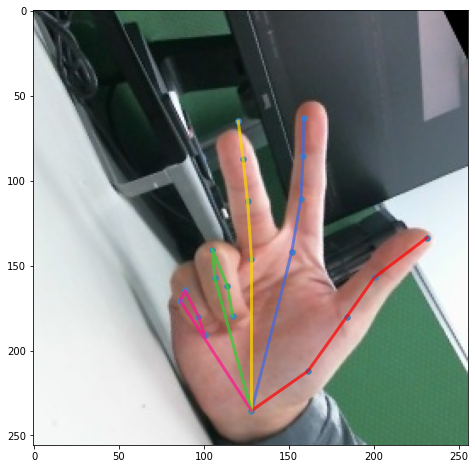

In [116]:
random_selected_file = os.path.split(np.random.choice(glob.glob('data/image/*')))[-1].split('.')[0]
image = cv2.imread(os.path.join('data', 'image', random_selected_file + '.jpg'))[:,:,::-1]
with open(os.path.join('data', 'annotation', random_selected_file + '.json')) as json_file: anno = json.load(json_file)
raw_image = image.copy()

plt.figure(figsize=(10,8))
draw_skeleton(np.array(anno['landmark']))
plt.imshow(raw_image)
plt.show()

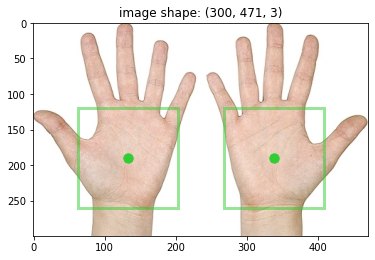

In [41]:
for i, landmarks in enumerate(landmarks_list):
    side = max_distance((landmarks*raw_image.shape[:2][::-1])[[0, 1, 2, 5, 9, 13, 17]])
    center = (landmarks*raw_image.shape[:2][::-1])[[0, 9]].sum(axis=0)/2
    plt.scatter(center[0], center[1], color='limegreen', s=87, alpha=1)
    rect = patches.Rectangle((center[0]-side/2,center[1]-side/2),
                             side, side, 
                             lw=3, ec='limegreen', ls='-', alpha=0.5, facecolor="none")
    plt.gca().add_patch(rect)

plt.imshow(raw_image[:,:,::-1])
plt.title("image shape: %s" % str(raw_image.shape))
plt.show()